In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras.losses import mse
from keras.optimizers import Adam
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
newDf = pd.read_csv('/content/drive/MyDrive/SDA Codes/CVAE_final/new_final_data.csv',low_memory=False)

In [ ]:
newDf = newDf.iloc[:, 1:]
newDf.rename(columns={'Unnamed: 0': 'EQID'}, inplace=True)

In [ ]:
# Assuming df is your DataFrame
newDf = newDf.apply(pd.to_numeric, errors='coerce')
newDf = newDf.astype(float)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
X = newDf[['PGA','PGD','Fp','Tsig','Ia','CAV','vs30','dir']]
column_names = X.columns
X = X[column_names].values
y = newDf[['EQID','0.01', '0.015', '0.02', '0.03', '0.04', '0.05', '0.06', '0.075',
       '0.09', '0.1', '0.15', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.75',
       '0.8', '0.9', '1', '1.2', '1.5', '2', '2.5', '3', '4']]
column_names = y.columns
y = y[column_names].values

# Normalize the data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test= train_test_split(X_normalized, y ,test_size=0.2, random_state=42)
y_train = np.log(Y_train[:, 1:])
y_test = np.log(Y_test[:, 1:])

In [ ]:
import numpy as np
from keras.models import load_model

# Load the models - CONDITIONAL MODEL (WITH MAPPING LAYERS) AND DECODER
encoder = load_model('.../conditional_model.h5')
decoder = load_model('.../decoder_model.h5')

PGA = float(input('Enter $PGA$: '))
PGD = float(input('Enter $PGD$: '))
Fp = float(input('Enter $Fp$: '))
Tsig = float(input('Enter $Tsig$: '))
Ia = float(input('Enter $Ia$: '))
CAV = float(input('Enter $CAV$: '))
vs30 = float(input('Enter $S_c$ (1/2/3) -> (A/B/C): '))
dir = float(input('Enter $dir$ (0/1) -> (h/v): '))
manual_input = np.array([[PGA,PGD,Fp,Tsig,Ia,CAV,vs30,dir]])

manual_input_reshaped = manual_input.reshape(1, -1)
manual_input_reshaped = scaler.transform(manual_input_reshaped)

# Encode the manual input using the encoder (conditional_model.h5)
latent_variables = encoder.predict(manual_input_reshaped)

# Print the manual input and check the shape of the latent variables - NOT MANDATORY
print('Manual Input:', manual_input)
print("Latent Variables Shape:", latent_variables)

# Decode the latent variables using the decoder (decoder_model.h5)
decoded_output = decoder.predict(latent_variables)

Enter $PGA$: 0.08
Enter $PGD$: 0.3
Enter $Fp$: 5.85
Enter $Tsig$: 2.04
Enter $Ia$: 0.97
Enter $CAV$: 26.4
Enter $S_c$ (1/2/3) -> (A/B/C): 1
Enter $dir$ (0/1) -> (h/v): 0
1/1 [==============================] - 0s 60ms/step
Manual Input: [[ 0.08  0.3   5.85  2.04  0.97 26.4   1.    0.  ]]
Latent Variables Shape: [[-3.232102  -2.0404778  4.0545278]]
1/1 [==============================] - 0s 77ms/step


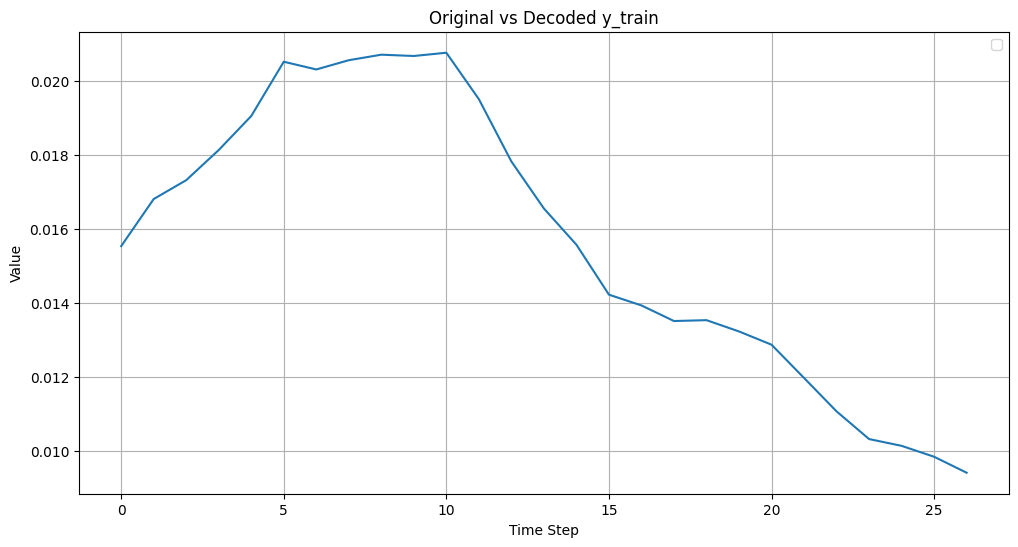

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(np.exp(decoded_output[0]))
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Original vs Decoded y_train')
plt.legend()
plt.grid(True)
plt.show()

# CONCATENATE - Creating a standalone model

In [ ]:
from keras.models import load_model, Model

# Load the encoder and decoder models
encoder = load_model('.../conditional_model.h5')
decoder = load_model('.../decoder_model.h5')

# Get the output of the encoder model
encoder_output = encoder.layers[-1].output

# Set the decoder model's input to be the output of the encoder
decoder_input = encoder_output
decoder_output = decoder(decoder_input)
"""
ACTUAL COMPILATION STARTS HERE
"""

# Create the concatenated model
autoencoder = Model(inputs=encoder.input, outputs=decoder_output)

# Compile the concatenated model (optional, if you want to use it for further training)
autoencoder.compile(optimizer='adam', loss='mse')  # Adjust optimizer and loss as needed

# Summary of the concatenated model
autoencoder.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_109_input (InputLaye  [(None, 8)]               0         
 r)                                                              
                                                                 
 dense_109 (Dense)           (None, 8)                 72        
                                                                 
 dense_110 (Dense)           (None, 4)                 36        
                                                                 
 dense_111 (Dense)           (None, 3)                 15        
                                                                 
 model_19 (Functional)       (None, 27)                831       
                                                                 
Total params: 954 (3.73 KB)
Trainable params: 954 (3.73 KB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

In [ ]:
from keras.models import load_model, Model, save_model

# Assuming you have already concatenated and compiled the model as 'autoencoder'

# Define the path where you want to save the model
save_path = '.../FINAL_CVAE_MODEL.h5'

# Save the model
save_model(autoencoder, save_path)

print(f"Concatenated model saved at {save_path}")

Concatenated model saved at /content/drive/MyDrive/SDA Codes/CVAE_final/final_model/FINAL_CVAE_MODEL.h5


<ipython-input-32-e96c46ec3da3>:9: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(autoencoder, save_path)


In [ ]:
import numpy as np
from keras.models import load_model

# Load the models
cvae = load_model('/content/drive/MyDrive/SDA Codes/CVAE_final/final_model/FINAL_CVAE_MODEL.h5')

PGA = float(input('Enter $PGA$: '))
PGD = float(input('Enter $PGD$: '))
Fp = float(input('Enter $Fp$: '))
Tsig = float(input('Enter $Tsig$: '))
Ia = float(input('Enter $Ia$: '))
CAV = float(input('Enter $CAV$: '))
vs30 = float(input('Enter $S_c$ (1/2/3) -> (A/B/C): '))
dir = float(input('Enter $dir$ (0/1) -> (h/v): '))
# Manually define an input array (example)
manual_input = np.array([[PGA,PGD,Fp,Tsig,Ia,CAV,vs30,dir]])


# Reshape the manual input array if needed (depending on the model's input shape)
manual_input_reshaped = manual_input.reshape(1, -1)
manual_input_reshaped = scaler.transform(manual_input_reshaped)

# Encode the manual input using the encoder (conditional_model.h5)
decoded_output = cvae.predict(manual_input_reshaped)
plt.figure(figsize=(12, 6))
plt.plot(np.exp(decoded_output[0]))
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Original vs Decoded y_train')
plt.legend()
plt.grid(True)
plt.show()